Let's make ML model to learn and predict user's recommendation based on their bookmarks using `LightGMB`.

- Firstly we load the data, this is where reviews file comes in handy.

In [12]:
import pandas as pd

# Check if the variables already exist in the global scope
if 'recipes' not in globals():
    recipes = pd.read_parquet("../resource/recipes.parquet")

if 'reviews' not in globals():
    reviews = pd.read_parquet("../resource/reviews.parquet")

# Display dataset structure
print(recipes.head())
print(reviews.head())


   RecipeId                               Name  AuthorId      AuthorName  \
0      38.0  Low-Fat Berry Blue Frozen Dessert      1533          Dancer   
1      39.0                            Biryani      1567        elly9812   
2      40.0                      Best Lemonade      1566  Stephen Little   
3      41.0     Carina's Tofu-Vegetable Kebabs      1586         Cyclopz   
4      42.0                       Cabbage Soup      1538       Duckie067   

  CookTime PrepTime TotalTime             DatePublished  \
0    PT24H    PT45M  PT24H45M 1999-08-09 21:46:00+00:00   
1    PT25M     PT4H   PT4H25M 1999-08-29 13:12:00+00:00   
2     PT5M    PT30M     PT35M 1999-09-05 19:52:00+00:00   
3    PT20M    PT24H  PT24H20M 1999-09-03 14:54:00+00:00   
4    PT30M    PT20M     PT50M 1999-09-19 06:19:00+00:00   

                                         Description  \
0  Make and share this Low-Fat Berry Blue Frozen ...   
1  Make and share this Biryani recipe from Food.com.   
2  This is from one 

Now, onto preprocessing. We'll clean the data and remove the bad ones.

In [13]:
if 'recipes' not in globals() and 'reviews' not in globals():
    # Drop rows with missing RecipeId (if any)
    recipes.dropna(subset=['RecipeId'], inplace=True)
    
    # Fill missing numerical values with the median
    recipes.fillna(recipes.median(numeric_only=True), inplace=True)
    
    # Convert categorical columns
    recipes['RecipeCategory'] = recipes['RecipeCategory'].astype('category')


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Ensure all entries are strings and handle missing values
recipes['RecipeIngredientParts'] = recipes['RecipeIngredientParts'].fillna("").astype(str)

# Apply TF-IDF Vectorization (keep it sparse)
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
tfidf_matrix = vectorizer.fit_transform(recipes['RecipeIngredientParts'])

# Merge TF-IDF sparse matrix back into recipes
# Reset index and concatenate in sparse format
recipes = pd.concat([recipes.reset_index(drop=True), pd.DataFrame.sparse.from_spmatrix(tfidf_matrix)], axis=1)


In [15]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.model_selection import train_test_split

# Ensure TF-IDF matrix is in sparse format and converted to float32
tfidf_matrix = tfidf_matrix.astype(np.float32)

# Compute the average rating for each recipe from reviews
avg_ratings = reviews.groupby('RecipeId')['Rating'].mean().reset_index()

# Merge the average ratings into recipes
recipes = recipes.merge(avg_ratings, on='RecipeId', how='left')

# Now drop rows with missing Rating values (the merged column is "Rating")
target = 'Rating'
recipes = recipes.dropna(subset=[target])

# Define numeric features (Rating comes from reviews now)
numeric_features = ['Calories', 'FatContent', 'CarbohydrateContent', 'ProteinContent', 'Rating']

# Instead of trying to select TF-IDF columns from recipes, split using indices.
train_idx, test_idx, y_train, y_test = train_test_split(recipes.index, recipes[target], test_size=0.2, random_state=42)

# Prepare numeric data
X_numeric = recipes[numeric_features].astype(np.float32)
X_train_numeric = sparse.csr_matrix(X_numeric.loc[train_idx].values)
X_test_numeric = sparse.csr_matrix(X_numeric.loc[test_idx].values)

# Select corresponding TF-IDF rows using the indices
X_train_tfidf = tfidf_matrix[train_idx]
X_test_tfidf = tfidf_matrix[test_idx]

# Combine numeric and TF-IDF features
X_train_sparse = sparse.hstack([X_train_numeric, X_train_tfidf])
X_test_sparse = sparse.hstack([X_test_numeric, X_test_tfidf])

# Create LightGBM datasets
train_data = lgb.Dataset(X_train_sparse, label=y_train)
test_data = lgb.Dataset(X_test_sparse, label=y_test, reference=train_data)


Now we can train and evaluate the model.

In [16]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(10)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118162
[LightGBM] [Info] Number of data points in the train set: 217339, number of used features: 505
[LightGBM] [Info] Start training from score 4.343284
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.0129929


In [17]:
# Save Model
import pickle

with open("recommendation_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved successfully!")

import joblib
from scipy import sparse

# Save the fitted TF-IDF vectorizer to a file
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Save the TF-IDF sparse matrix to a file (we'll use a compressed format to save space)
sparse.save_npz('tfidf_matrix.npz', tfidf_matrix)


Model saved successfully!


Test RMSE: 0.0130
Test R² Score: 0.9998


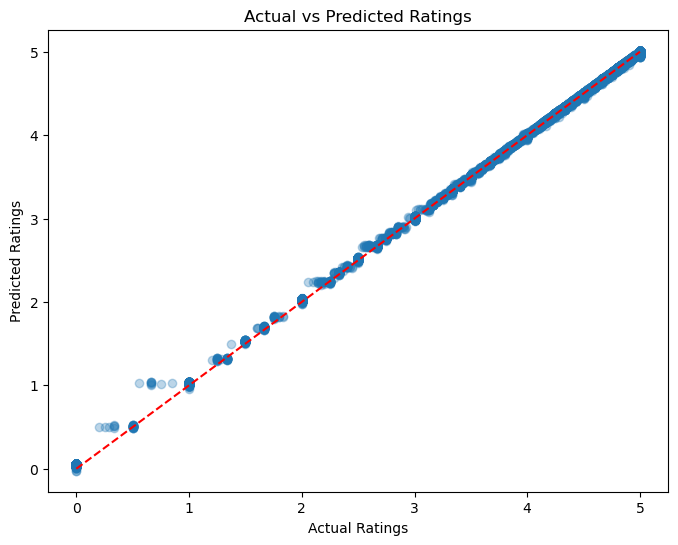

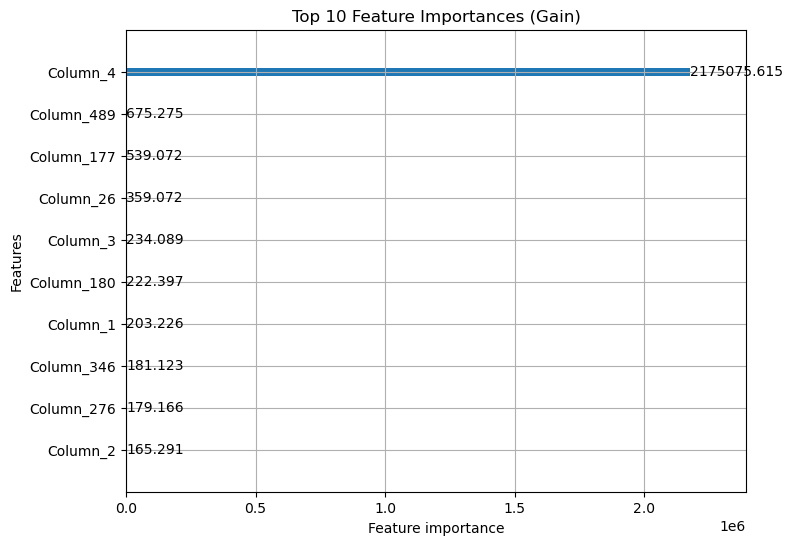

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data using the best iteration from early stopping
y_pred = model.predict(X_test_sparse, num_iteration=model.best_iteration)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Test RMSE: {:.4f}".format(rmse))
print("Test R² Score: {:.4f}".format(r2))

# Plot Actual vs. Predicted Ratings
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Ratings")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

# Plot feature importances for top 10 features
ax = lgb.plot_importance(model, max_num_features=10, importance_type='gain', figsize=(8, 6))
plt.title("Top 10 Feature Importances (Gain)")
plt.show()


Note that:
- `RMSE`: A value `Closer to 0` indicate better performance.
- `R² Score`: A value `closer to 1` indicates a better model fit.